#### ※ 이 프로젝트는 저를 포함한 6명의 팀원들과 진행한 프로젝트입니다.

# 1. 문제 상황 정의
최근 인공지능(AI) 및 딥 러닝 기술이 상용화되면서 어느 기업이든 분야를 막론하고 이를 활용하여 서비스 개발 및 개선에 지대한 관심을 보이고 있다. 특히 자연어 처리(NLP) 분야는 음성인식, 검색최적화, 텍스트분류 등 클라이언트가 더욱 쉽게 서비스에 접근할 수 있도록 만드는 기술인만큼 크게 주목 받고 있다. 이에 우리는 국내 최대 온라인 의류 쇼핑몰 중 하나인 WUSINSA의 상품 리뷰 댓글 텍스트를 개체명인식(NER)으로 처리하고 속성별로 분류하여, 향후 클라이언트의 검색 편의성을 제고할 수 있는 모델을 만들고자 한다.

# 2. 데이터 수집 및 탐색적 데이터 분석(EDA)

## 2-1. 데이터 수집
데이터는 별도의 웹 크롤러 프로그램을 통해 txt 파일로 수집하였다. 최대한 일반적이고 풍부한 표본을 수집하기 위해 리뷰 댓글이 100개 이상인 상품들을 상위로 하여 수집하였으며, 댓글의 내용이 한 상품으로만 치우치는 것을 방지하기 위하여 총 45개의 세부 카테고리별로 일정 비율에 의해 추출하였다. 총 4500여 개의 표본이 수집되었으나, 모델 학습을 위해 팀원들이 일일이 텍스트에 태깅작업을 해야하므로 프로젝트 기간을 고려해 이중 1500여 개의 데이터만 사용하기로 결정하였다. 

## 2-2. 탐색적 데이터 분석(EDA)

In [3]:
import pandas as pd

train = pd.read_csv("train.csv")

In [4]:
train.head()

,리뷰 텍스트
0,생각보다 무난해서 더 좋았던것 같아요 ! 뭔가 디테일이 많이 튈거라고 생각해서 걱정했는데
1,사진에 보이는 색상처럼 괜찮은 독특한 블루색입니다 기모가 쨩쨩해서 춥진 않을듯합니다...
2,재질도좋고 촉감도 좋습니다~ 배송 역시 빠르고 마니파세요
3,교복에 입기 정말 무난한 후드집업 ㅎㅎ 사이즈도 넉넉하니 귀여워요
4,생각보다 조금 얇은 느낌이긴 한데 그래서 여름에 입기 좋은 것 같아요


In [5]:
train.tail()

,리뷰 텍스트
1574,제가 가슴이 좀 있는편이어서 한사이즈 크게 샀는데 원하는 사이즈에 핏이 였음요
1575,"스몰로 샀는데도 넉넉한 기장, 품, 핏입니다. 오버핏 확실하고 무겁습니다. 생각보다..."
1576,유튜버분의 착용샷을 보고 구매했는데 받아보니 색감이 선명하고 편하고 이쁩니다!
1577,너무 이쁘고 패셔너블하네오 무조건 사시는거 추천!
1578,실측사이즈만 봤을때 작을까봐 걱정했는데 오버핏으로나와서 안에 껴입기도 좋고 요즘날씨...


리뷰 텍스트는 보통 온라인에서 사용하는 방식으로 작성되었다. 따라서 띄어쓰기나 맞춤법이 제대로 지켜지지 않는 상태로 작성되며, 외래어와 은어, 신조어, 이모티콘 등의 사용이 빈번하게 일어난다. 또한 영어 텍스트와는 달리 한국어 텍스트는 조사의 사용이 빈번하기 때문에 띄어쓰기를 기준으로 토큰화(Tokenization)할 경우 '사이즈가'라는 토큰과 '사이즈는'이라는 토큰을 다른 단어로 인식하는 문제가 발생하게 된다. 

# 3. 데이터 전처리
앞서 언급한 문제들로 인해 우선 맞춤법과 띄어쓰기를 교정해줄 필요가 있으며, 이를 바탕으로 일정 수준 교정된 텍스트를 형태소 기준으로 토큰화해야만 조사를 분리할 수 있다.

In [ ]:
# 필요 패키지 다운로드

# 한국어 토큰화에 필요한 KoNLPy
!apt-get update 
!apt-get install g++ openjdk-8-jdk python-dev python3-dev 
!pip3 install JPype1-py3 
!pip3 install konlpy 
!JAVA_HOME="C:\Program Files\Java\jdk1.8.0_291" #본인 pc의 jdk 설치 경로
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
# 맞춤법, 띄어쓰기 교정을 위한 Hanspell
!pip3 install git+https://github.com/ssut/py-hanspell.git

In [ ]:
from konlpy.tag import Okt #한국어 형태소 분석기
from konlpy.tag import Kkma #한국어 형태소 분석기
from konlpy.tag import Mecab #한국어 형태소 분석기
from hanspell import spell_checker #한국어 맞춤법 교정기

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # 학습용 데이터셋과 테스트용 데이터셋 분기 위함.
from tqdm import tqdm # 진행 상황 바를 표시하여주는 라이브러리.
from collections import Counter # 등장 단어 빈도수 계산 위함.

## 3-1. 맞춤법 교정 처리 (Py-Hanspell)

In [ ]:
train_checked = train['리뷰 텍스트']

for i in tqdm(range(len(train))): 
  result_train = spell_checker.check(train['리뷰 텍스트'][i]) 
  train_checked[i] = result_train.as_dict()['checked'] 


100%|██████████| 1579/1579 [06:28<00:00,  4.06it/s]


In [6]:
train.head() # 처리 전

,리뷰 텍스트
0,생각보다 무난해서 더 좋았던것 같아요 ! 뭔가 디테일이 많이 튈거라고 생각해서 걱정했는데
1,사진에 보이는 색상처럼 괜찮은 독특한 블루색입니다 기모가 쨩쨩해서 춥진 않을듯합니다...
2,재질도좋고 촉감도 좋습니다~ 배송 역시 빠르고 마니파세요
3,교복에 입기 정말 무난한 후드집업 ㅎㅎ 사이즈도 넉넉하니 귀여워요
4,생각보다 조금 얇은 느낌이긴 한데 그래서 여름에 입기 좋은 것 같아요


In [ ]:
train_checked.head() # 처리 후 

0    생각보다 무난해서 더 좋았던 것 같아요! 뭔가 디테일이 많이 튈 거라고 생각해서 걱...
1    사진에 보이는 색상처럼 괜찮은 독특한 블루색입니다 기모가 쨩쨩해서 춥진 않을듯합니다...
2                    재질도 좋고 촉감도 좋습니다~ 배송 역시 빠르고 많이 파세요
3                 교복에 입기 정말 무난한 후드집업 ㅎㅎ 사이즈도 넉넉하니 귀여워요
4               생각보다 조금 얇은 느낌이긴 한데 그래서 여름에 입기 좋은 것 같아요
Name: 리뷰 텍스트, dtype: object

In [ ]:
train_checked.to_csv("train_checked.csv", index = None)

In [ ]:
train = pd.read_csv("train_checked.csv")
train.head()

,리뷰 텍스트
0,생각보다 무난해서 더 좋았던 것 같아요! 뭔가 디테일이 많이 튈 거라고 생각해서 걱...
1,사진에 보이는 색상처럼 괜찮은 독특한 블루색입니다 기모가 쨩쨩해서 춥진 않을듯합니다...
2,재질도 좋고 촉감도 좋습니다~ 배송 역시 빠르고 많이 파세요
3,교복에 입기 정말 무난한 후드집업 ㅎㅎ 사이즈도 넉넉하니 귀여워요
4,생각보다 조금 얇은 느낌이긴 한데 그래서 여름에 입기 좋은 것 같아요


## 3-2. 토큰화(Tokenization)(Okt 형태소 분석기)
Okt, Kkma, Mecab 각 한국어 형태소 분석기의 결과를 비교해 본 결과, Okt가 데이터에 대해 가장 직관적인 토큰화를 구현하여 주므로 Okt 형태소 분석기를 사용하기로 결정하였다.

In [ ]:
okt = Okt()

train_tokenized = []

for i in tqdm(range(len(train))): 
  train_tokenized.append(okt.morphs(train['리뷰 텍스트'][i]))

100%|██████████| 1579/1579 [00:13<00:00, 118.63it/s]


In [ ]:
print(train_tokenized)

## 3-3. 불용어 정제
분리된 조사와 이모티콘, 특수문자 등 개체명인식에 필요하지 않은 텍스트를 정제하기 위해 불용어 사전을 별도로 정의하였다.

In [ ]:
all_words_list = sum(train_tokenized, []) # 토큰화한 단어의 리스트를 하나의 리스트로 합침
print(all_words_list)

In [ ]:
words = Counter(all_words_list) # 각 단어 별 빈도 수 계산.
print(words) # 불용어 사전 정의에 참고하기 위해 확인.

In [ ]:
word_tokens = train_tokenized # 토큰화 한 학습 데이터
file = open("stopwords.csv", "r") # 불용어 사전 파일 오픈
stop_words = file.read().split("\n") # 각 단어는 개행으로 구분되어 있으므로 \n을 구분자로 사용하여 리드
file.close()
result = [] # 결과 저장위한 변수 선언

for i in range(0, len(word_tokens)): # 데이터 길이(문장 갯수만큼 반복)
  result.append([word for word in word_tokens[i] if not word in stop_words]) 
  # 각 문장마다 불용어 사전에 없는 토큰을 result에 append 

print('불용어 제거 전 :',word_tokens) 
print('불용어 제거 후 :',result)
print(stop_words)

# 아래 코드는 데이터 처리 결과를 더 직관적으로 확인하기 위함
temp = pd.DataFrame()
temp['불용어 제거 전'] = word_tokens
temp['불용어 제거 후'] = result
print(temp)

In [ ]:
print(max(len(l) for l in word_tokens)) # 불용어 처리 전 문장의 최대 길이 : 131
print(max(len(l) for l in result)) # 불용어 처리 후 문장의 최대 길이 : 82

131
82


In [ ]:
temp.to_csv("stopwords_processed.csv", index = None)

## 3-4. 태깅(Tagging)
불용어를 정제한 데이터에 각 토큰마다 태그를 작성하였다. 정의한 태그는 다음과 같다.

*   사이즈 SIZ / Size
*   만족도 SAT / Satisfaction
*   디자인 DES / Design
*   색상 COL / Color
*   가격 PRC / Price
*   착용감 COW / Comfort of wearing
*   품질 QLT / Quality
*   소재 MTR / Meterial
*   코디 COD / Coordinate
*   관리 MNG / Manage
*   무게 WGT / Weight
*   보온성 TMP / Temperature
*   배송 DLV / Delivery

태그는 BIO 표현방식을 따르며, 개체가 시작되는 지점은 B(Begin), 개체에 포함 되는 부분은 I(Inside), 개체가 아닌 부분은 O(Outside)로 표기한다. 예를 들어 '사이즈', '커요', '정말'이라는 토큰이 연속해서 있을 경우 각각 'B-SIZ', 'I-SIZ', 'O'로 태깅한다.

In [ ]:
import re # 정규표현식 사용 위함
import matplotlib.pyplot as plt # 도표 시각화 위함

In [ ]:
f = open('tagging_complete.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0]
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

print(tagged_sentences)
print("전체 문장 개수: ", len(tagged_sentences))

In [ ]:
tagged_sentences[375][14] = ['x', 'O'] # 불용어 처리시 정제되지 못한 이모티콘을 의미 없는 값으로 바꿔줌.

In [ ]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 문장들을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 문장의 단어들은 sentence에, 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 문장에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 문장에서 개체명 태깅 정보만 저장한다.

print('첫번째 문장 :',sentences[0])
print('첫번째 문장의 태그 :',ner_tags[0])
print(len(sentences))
print(len(ner_tags))

첫번째 문장 : ['무난', '해서', '좋았던', '같아요', '뭔가', '디테', '일이', '튈', '라고', '해서', '걱정']
첫번째 문장의 태그 : ['B-DES', 'I-DES', 'I-DES', 'O', 'O', 'B-DES', 'I-DES', 'I-DES', 'O', 'O', 'O']
1578
1578


In [ ]:
all_tags_list = sum(ner_tags, [])
tags_len = Counter(all_tags_list)
print(tags_len)

Counter({'O': 10224, 'B-SIZ': 1405, 'B-SAT': 1310, 'I-SIZ': 721, 'B-MTR': 458, 'B-TMP': 384, 'B-COW': 342, 'B-COL': 337, 'B-DES': 320, 'I-SAT': 250, 'I-MTR': 189, 'B-COD': 176, 'I-COD': 169, 'I-DES': 165, 'I-COL': 151, 'I-COW': 143, 'B-QLT': 138, 'B-PRC': 131, 'B-WGT': 94, 'I-QLT': 85, 'B-DLV': 70, 'I-PRC': 67, 'I-DLV': 65, 'I-TMP': 54, 'B-MNG': 46, 'I-MNG': 23, 'I-WGT': 23, '': 23})


리뷰 데이터 최대 길이 : 82
리뷰 데이터 평균 길이 : 11.129911


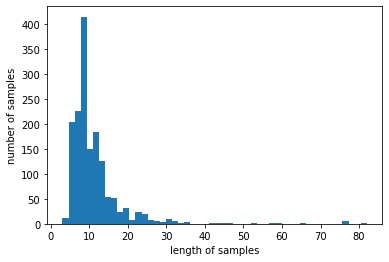

In [ ]:
print('리뷰 데이터 최대 길이 : %d' % max(len(sentence) for sentence in sentences))
print('리뷰 데이터 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(sentence) for sentence in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

학습용 데이터 중 가장 긴 문장의 82의 길이를 가지며, 주로 40이하의 길이이고 평균적으로 10 내외의 길이를 가짐.

## 3-5. 정수 인코딩(Integer Encoding)
각 단어에 정수 값을 부여하여 컴퓨터가 연산할 수 있도록 처리하기 위한 작업이다. 이를 위해 단어 빈도 수에 따른 단어 집합을 만들고, 그 순서대로 인덱스를 부여한다.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
src_tokenizer = Tokenizer(oov_token='OOV') # 토큰화한 적이 없는 단어는 'OOV'로 처리해주기 위해 선언한 파라미터임.
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

vocab_size = len(src_tokenizer.word_index) + 1 # OOV를 추가해주었기 때문에 1을 더해줌
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 3816
개체명 태깅 정보 집합의 크기 : 29


In [ ]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

print('첫번째 문장 :',X_data[0])
print('첫번째 문장의 레이블 :',y_data[0])

첫번째 문장 : [23, 41, 1741, 4, 312, 884, 1169, 1742, 460, 41, 103]
첫번째 문장의 레이블 : [9, 14, 14, 1, 1, 9, 14, 14, 1, 1, 1]


In [ ]:
word_to_index = src_tokenizer.word_index 
index_to_word = src_tokenizer.index_word #모델 학습 후 결과 확인을 위해 인덱스로부터 단어를 리턴
ner_to_index = tar_tokenizer.word_index 
index_to_ner = tar_tokenizer.index_word #인덱스로부터 개체명 태깅 정보를 리턴
index_to_ner[0] = 'PAD'

print(index_to_ner)

{1: 'o', 2: 'b-siz', 3: 'b-sat', 4: 'i-siz', 5: 'b-mtr', 6: 'b-tmp', 7: 'b-cow', 8: 'b-col', 9: 'b-des', 10: 'i-sat', 11: 'i-mtr', 12: 'b-cod', 13: 'i-cod', 14: 'i-des', 15: 'i-col', 16: 'i-cow', 17: 'b-qlt', 18: 'b-prc', 19: 'b-wgt', 20: 'i-qlt', 21: 'b-dlv', 22: 'i-prc', 23: 'i-dlv', 24: 'i-tmp', 25: 'b-mng', 26: 'i-mng', 27: 'i-wgt', 28: '', 0: 'PAD'}


In [ ]:
X_data = pad_sequences(X_data, padding='post')
y_data = pad_sequences(y_data, padding='post')

X_train, X_test, y_train_int, y_test_int = train_test_split(X_data, y_data, test_size=.1, random_state=1000)
# 검증용 데이터 10% 추출

y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

print('학습 문장 데이터의 크기 : {}'.format(X_train.shape))
print('학습 태그 데이터(정수 인코딩)의 크기 : {}'.format(y_train_int.shape))
print('학습 태그 데이터(원-핫 인코딩)의 크기 : {}'.format(y_train.shape))
print('검증 문장 데이터의 크기 : {}'.format(X_test.shape))
print('검증 태그 데이터(정수 인코딩)의 크기 : {}'.format(y_test_int.shape))
print('검증 태그 데이터(원-핫 인코딩)의 크기 : {}'.format(y_test.shape))

학습 문장 데이터의 크기 : (1420, 82)
학습 태그 데이터(정수 인코딩)의 크기 : (1420, 82)
학습 태그 데이터(원-핫 인코딩)의 크기 : (1420, 82, 29)
검증 문장 데이터의 크기 : (158, 82)
검증 태그 데이터(정수 인코딩)의 크기 : (158, 82)
검증 태그 데이터(원-핫 인코딩)의 크기 : (158, 82, 29)


# 4. BiLSTM을 이용한 모델링
학습 모델은 이 프로젝트의 목적이 리뷰 텍스트의 개체명인식이라는 점을 고려하였을 때, 여러 개의 입력과 여러 개의 출력이 존재하는 다 대 다(Many to many) 구조이므로 순환신경망(RNN)구조로 학습하는 것이 적절하며, 이전 시점과 이후 시점을 모두 고려하여 학습하고 기억할 필요가 있는 데이터를 기억하며 학습하는 BiLSTM이 개체명인식에 가장 적합하다고 판단하였다.



은닉층과 학습률, 에포크를 조정하며 각 모델의 정확도를 측정한 결과, 은닉층은 256, 학습률은 0.01, 에포크는 7일 때 가장 정확도가 높게 나타났다.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=128, epochs=7, validation_split=0.1)

Epoch 1/7
10/10 [==============================] - 38s 2s/step - loss: 0.3231 - accuracy: 0.5190 - val_loss: 0.2539 - val_accuracy: 0.5908
Epoch 2/7
10/10 [==============================] - 18s 2s/step - loss: 0.2319 - accuracy: 0.5891 - val_loss: 0.2212 - val_accuracy: 0.6165
Epoch 3/7
10/10 [==============================] - 19s 2s/step - loss: 0.1768 - accuracy: 0.6599 - val_loss: 0.1843 - val_accuracy: 0.6887
Epoch 4/7
10/10 [==============================] - 18s 2s/step - loss: 0.1271 - accuracy: 0.7578 - val_loss: 0.1552 - val_accuracy: 0.7419
Epoch 5/7
10/10 [==============================] - 19s 2s/step - loss: 0.0884 - accuracy: 0.8161 - val_loss: 0.1433 - val_accuracy: 0.7645
Epoch 6/7
10/10 [==============================] - 17s 2s/step - loss: 0.0627 - accuracy: 0.8576 - val_loss: 0.1447 - val_accuracy: 0.7731
Epoch 7/7
10/10 [==============================] - 17s 2s/step - loss: 0.0475 - accuracy: 0.8868 - val_loss: 0.1513 - val_accuracy: 0.7700


# 5. 결과물 출력

In [ ]:
for i in range(0, 20): # 상위 20개 결과 출력
    y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
    y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 인코딩으로 변경함.
    labels = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

    print("{:15}|{:5}|{}".format("\n단어", "실제값", "예측값"))
    print(35 * "-")

    for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
        if word != 0: # PAD값은 제외함.
            print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))


단어            |실제값  |예측값
-----------------------------------
한겨울              : b-tmp   b-tmp
만                : o       o
빼면               : o       o
초가을              : b-tmp   b-tmp
초봄               : b-tmp   o
있는               : o       o
두께               : b-mtr   b-mtr
감                : i-mtr   o
아우               : o       o
터                : o       o
강추               : b-sat   b-sat

단어            |실제값  |예측값
-----------------------------------
교복               : b-cod   o
위                : i-cod   o
에다가              : i-cod   o
입기도              : i-cod   o
좋았고              : o       b-sat
핏                : b-siz   b-siz
이쁘고              : i-siz   i-siz
그냥               : o       o
기본               : o       o
무난               : b-des   o
후드               : o       o
티                : o       o
인                : o       o
같아요              : o       o
회색               : b-col   b-col
있어야              : o       o
같아서              : o       o
샀어요              : o       o
이뻐요

# 6. 개선방향
전체적으로 빈도수가 높은 태그에 대해서는 비교적 정확하게 예측해내는 모습을 볼 수 있었지만, 원천 데이터의 수 자체가 적어 에포크가 높아질수록 특정 시점부터 검증 정확도가 들쭉날쭉해지는 과대적합 현상이 발생하였고, 0.76에서 0.77정도의 값에서 더 이상 높아지지 않았다. 이에 추후 개선할 방향을 제시해보고자 한다.



1.   절대적인 표본 크기 확보


>  자연어처리 학습에는 최소 수 만개의 데이터가 요구되나, 태깅 작업에 소요되는 시간이 많아 1500여 개의 문장을 태깅하는데 그쳤다. 이후 충분한 시간을 두고 태깅 작업을 하여 1만 개 이상의 데이터를 확보한다면 과대적합 문제는 해소될 것으로 기대된다.



2.   태깅 작업의 일관성 확보


>  태깅 작업은 결국 사람이 수동으로 해주는 작업이므로 태깅의 기준을 정하더라도 한국어 자연어의 모호성 때문에 태깅을 작성하는 사람의 주관이 주입될 수밖에 없었다. 이에 따라 같은 문맥과 단어에도 다른 태그가 붙은 경우로 인해 학습이 제대로 작동하지 못한 부분이 발생하였다. 태깅 작업에 있어서 조금 더 명확한 기준을 정하는 등의 방편이 필요한 것으로 보인다.



3.   전처리 방식 개선


>  이 프로젝트에서는 한국어 맞춤법 교정기가 형태소 분석기를 제대로 동작하게끔 만들기 위해 반드시 필요한 것으로 판단하였으나, 오히려 형태소 분석에 어려운 형태로 변환한 경우도 다수 발생하였다. 따라서 리뷰 텍스트에서 자주 등장하는 단어를 별도로 사전에 등록하여 이를 기반으로 맞춤법 교정 및 토큰화가 이루어질 수 있도록 처리하고, 불용어 사전 또한 제거할 단어를 보다 다각적으로 분석하여 정의할 필요가 있을 것으로 보인다.
